# TensorFlow的分类器模型构建(监督学习)

## 准备工作

### 导入基本的库

In [1]:
import os
from tensorflow import keras
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# 这串代码让图像直接显示在Notebook里而不是单独打开一个窗口
%matplotlib inline

#### 接着我们把这些库的版本打印出来

In [2]:
for module in (mpl, np, pd, sklearn, tf, keras):
    print(module.__name__, "的版本是: ", module.__version__)

matplotlib 的版本是:  3.1.0
numpy 的版本是:  1.16.4
pandas 的版本是:  0.24.2
sklearn 的版本是:  0.21.2
tensorflow 的版本是:  2.0.0-beta1
tensorflow.python.keras.api._v2.keras 的版本是:  2.2.4-tf


### 导入与处理数据

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

# 打印数据大小
for dataset in x_train_all, y_train_all, x_test, y_test:
    print(dataset.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


##### 首先keras会帮们下载这个数据集，下载完成后，我们再将训练集的数据分成 训练集 和 验证集
我们把训练集的前5000个数据分配给验证集， 剩下的就是训练集  
### 注意
别忘了把**标签**也分成验证集和训练集

In [4]:
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# 打印训练集 验证集 测试集的shape
print("训练集: \n", x_train.shape, y_train.shape)
print("验证集: \n", x_valid.shape, y_valid.shape)
print("测试集: \n", x_test.shape, y_test.shape)

训练集: 
 (55000, 28, 28) (55000,)
验证集: 
 (5000, 28, 28) (5000,)
测试集: 
 (10000, 28, 28) (10000,)


## 显示图像

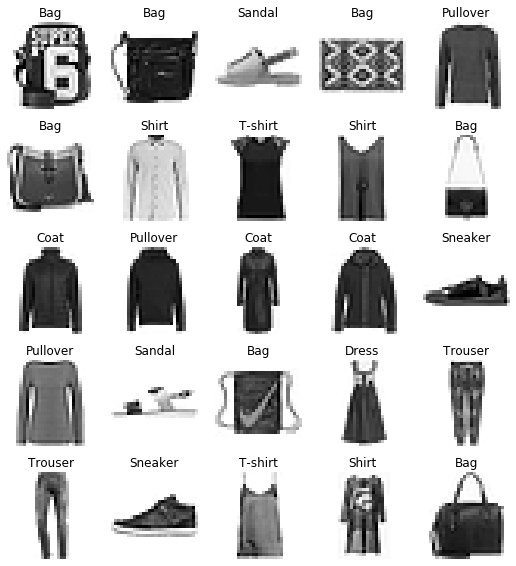

In [5]:
def show_datasets(data, label, rows, cols):

    class_name = [
        'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    plt.figure(figsize=(cols*1.8, rows*2.0))
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, cols * row + col + 1)
            random_pic = np.random.randint(0, label.shape[0])
            plt.imshow(data[random_pic], cmap='binary')
            plt.axis('off')
            plt.title(class_name[label[random_pic]])
    plt.show()


# 调用函数
show_datasets(x_train, y_train, 5, 5)

## 模型构建
这里我们使用
```py
tf.keras.models.Sequential()
```
来构建模型  

#### [TensorFlow官方API文档 Sequential](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/Sequential)

这个Sequential的本质就是把神经网络的层堆叠起来
> **`layers`**: list of layers to add to the model.

### 创建一个模型对象

In [14]:
# 创建一个Sequential对象
'''
model = tf.keras.models.Sequential()
# 调用Sequential对象的.add方法，添加神经网络层
model.add(keras.layers.Flatten(input_shape=[28 , 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
'''

#另一种写法，每次不用再调用.add方法可以直接写成一个list
model = tf.keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28 , 28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10 , activation = "softmax")
])

- $ReLU: y = max (0 , x)$
****

- $Softmax$函数把一个向量变成一个概率分布  
假设$y =  \begin{bmatrix} x1 & x2 & x3 \end{bmatrix}$  
$softmax(x): y = [\frac{e ^ {x1}}  {sum(x)} , \frac{e^{x2}} {sum(x)} , \frac{e^{x3}} {sum(x)}] $  
并且$sum(softmax(x)) = 1$

### 编译这个模型
```py
model.compile()
```
#### 参数
- `loss` 损失函数  
    这里使用的**sparse_categorical_crossentropy**的原因是 label --> index.  
    我们需要把label映射成一个概率分布的向量  
    看起来像这样
    ```py
    np.identity(10)
    >>> array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
       ```
       
 如果label本身就是一个概率分布的向量的话就直接使用  
 **categorical_crossentropy**
 - `optimizer` 优化器  
     sgd表示Stochastic Gradient Descent（随机梯度下降法）
     
- `matrics`  
    List of metrics to be evaluated by the model during training
    and testing. Typically you will use `metrics=['accuracy']`.     

In [15]:
# 构建图
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'sgd',
    metrics=["accuracy"]
             )

### 查看构建好的模型

In [16]:
#模型的神经网络层
model.layers

In [17]:
#概况
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## 训练模型
调用`fit()`方法来训练模型

In [18]:
history = model.fit(x_train , y_train , 
          epochs=10,
         validation_data = (x_valid , y_valid)
         )

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 14.5364 - accuracy: 0.0981 - val_loss: 14.3258 - val_accuracy: 0.1112
Epoch 2/10
55000/55000 [==============================] - 4s 75us/sample - loss: 14.5224 - accuracy: 0.0990 - val_loss: 14.3258 - val_accuracy: 0.1112
Epoch 3/10
 1504/55000 [..............................] - ETA: 3s - loss: 14.4141 - accuracy: 0.1057

KeyboardInterrupt: 

In [11]:
history.history

{'loss': [14.52207454403964,
  14.522696830194647,
  14.522696839349921,
  14.522696821316806,
  14.522696829639782,
  14.52269683824019,
  14.522696826033158,
  14.522696826310591,
  14.522696816600453,
  14.522696835188432],
 'accuracy': [0.09901818,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182,
  0.09898182],
 'val_loss': [14.325763063049317,
  14.325763075256347,
  14.325763079833985,
  14.325763081359863,
  14.325763079833985,
  14.325763032531738,
  14.325763073730469,
  14.325763043212891,
  14.325763050842285,
  14.325763006591798],
 'val_accuracy': [0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112,
  0.1112]}

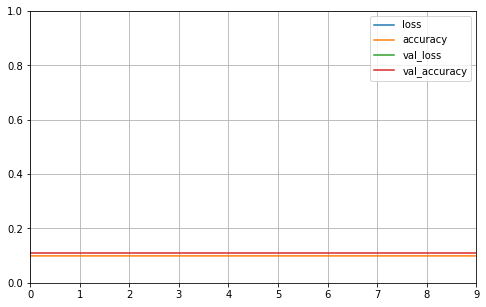

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)    